## Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('Combined_Flights_2022.csv', nrows=200000)

# Drop post-event columns
post_event_columns = [
    'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime', 'ArrDelayMinutes', 
    'AirTime', 'ActualElapsedTime', 'DepartureDelayGroups', 'TaxiOut', 
    'WheelsOff', 'WheelsOn', 'TaxiIn', 'ArrDelay', 'ArrDel15', 
    'ArrivalDelayGroups', 'DivAirportLandings'
]
df = df.drop(columns=post_event_columns)

# Drop additional columns based on your list
columns_to_drop = [
    'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
    'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline', 'DOT_ID_Operating_Airline', 
    'IATA_Code_Operating_Airline', 'Tail_Number', 'Flight_Number_Marketing_Airline', 
    'Flight_Number_Operating_Airline', 'OriginAirportID', 'OriginAirportSeqID', 
    'OriginCityMarketID', 'OriginStateFips', 'OriginStateName', 'OriginWac', 
    'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestStateFips', 
    'DestStateName', 'DestWac', 'DistanceGroup','Operating_Airline'
]
df = df.drop(columns=columns_to_drop)

# Drop rows with missing values
df = df.dropna()

# Convert 'FlightDate' to datetime and extract date-based features
df['FlightDate'] = pd.to_datetime(df['FlightDate'], errors='coerce')
df['DayOfWeek'] = df['FlightDate'].dt.dayofweek  # 0=Monday, 6=Sunday
df['Month'] = df['FlightDate'].dt.month  # 1=January, 12=December
df['DayOfMonth'] = df['FlightDate'].dt.day  # Day of the month (1-31)
df['Year'] = df['FlightDate'].dt.year  # Year (e.g., 2022)
df = df.drop(columns=['FlightDate'])

# Encode low-cardinality categorical columns with one-hot encoding
low_cardinality_cols = ['DepTimeBlk', 'ArrTimeBlk']
df = pd.get_dummies(df, columns=low_cardinality_cols, drop_first=True)

# Encode high-cardinality categorical columns with label encoding
high_cardinality_cols = ['Airline', 'Origin', 'Dest', 'OriginCityName', 'OriginState', 'DestCityName', 'DestState']
label_encoders = {}
for col in high_cardinality_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Verify all features are numeric
non_numeric_columns = df.select_dtypes(include=['object']).columns
if not non_numeric_columns.empty:
    print(f"Remaining non-numeric columns: {list(non_numeric_columns)}")
else:
    print("All features are numeric. Proceeding with scaling.")

# Define features (X) and target (y)
X = df.drop(columns=['DepDel15'])  # Features
y = df['DepDel15']  # Target

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

All features are numeric. Proceeding with scaling.


## Train/Test Split for Dataset

In [5]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Resample with SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)


## Training and Testing models with default parameters

In [7]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# XGBoost
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1)
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Logistic Regression
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_resampled, y_train_resampled)
y_pred_logreg = logreg_model.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))


XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87     29564
         1.0       0.63      0.42      0.50      9738

    accuracy                           0.79     39302
   macro avg       0.73      0.67      0.69     39302
weighted avg       0.78      0.79      0.78     39302

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85     29564
         1.0       0.56      0.47      0.51      9738

    accuracy                           0.78     39302
   macro avg       0.69      0.67      0.68     39302
weighted avg       0.76      0.78      0.77     39302

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.64      0.74     29564
         1.0       0.39      0.69      0.49      9738

    accuracy                           0.65     39302
   macro avg     

## Hyperparameter Tuning

In [9]:
from sklearn.model_selection import RandomizedSearchCV

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}
random_search = RandomizedSearchCV(XGBClassifier(eval_metric='logloss'), param_distributions=param_grid_xgb, 
                                   n_iter=50, cv=3, scoring='f1', random_state=42, verbose=1)
random_search.fit(X_train_resampled, y_train_resampled)
print("Best Parameters for XGBoost:", random_search.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters for XGBoost: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.7}


## Retraining with the Best Parameters

In [11]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Retrain XGBoost with the best parameters
optimized_xgb_model = XGBClassifier(
    subsample=0.7,
    n_estimators=200,
    max_depth=7,
    learning_rate=0.01,
    colsample_bytree=0.7,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Train the model on resampled data
optimized_xgb_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the test set
y_pred_optimized = optimized_xgb_model.predict(X_test)
y_pred_proba_optimized = optimized_xgb_model.predict_proba(X_test)[:, 1]

# Classification report
print("Optimized XGBoost Classification Report:")
print(classification_report(y_test, y_pred_optimized))

# Confusion matrix
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
print("Confusion Matrix:")
print(cm_optimized)

# AUC-ROC
auc_optimized = roc_auc_score(y_test, y_pred_proba_optimized)
print(f"AUC-ROC Score: {auc_optimized:.2f}")

Optimized XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83     29564
         1.0       0.50      0.57      0.53      9738

    accuracy                           0.75     39302
   macro avg       0.67      0.69      0.68     39302
weighted avg       0.76      0.75      0.76     39302

Confusion Matrix:
[[23974  5590]
 [ 4211  5527]]
AUC-ROC Score: 0.77


## Evaluating the performance of SVM

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


# Train SVM
print("Training SVM on scaled data (10K rows)...")
svm_model = SVC(kernel='linear', probability=True, max_iter=1000, random_state=42)

svm_model.fit(X_train_resampled, y_train_resampled)

# Evaluate SVM
y_pred_svm = svm_model.predict(X_test)
y_pred_proba_svm = svm_model.decision_function(X_test)

print("SVM Evaluation:")
print(classification_report(y_test, y_pred_svm))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba_svm))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))


Training SVM on scaled data (10K rows)...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM Evaluation:
              precision    recall  f1-score   support

         0.0       0.80      0.49      0.61     29564
         1.0       0.29      0.62      0.39      9738

    accuracy                           0.52     39302
   macro avg       0.54      0.56      0.50     39302
weighted avg       0.67      0.52      0.56     39302

AUC-ROC Score: 0.576010529450274
Confusion Matrix:
[[14592 14972]
 [ 3710  6028]]


## Generate ROC curve data for each model

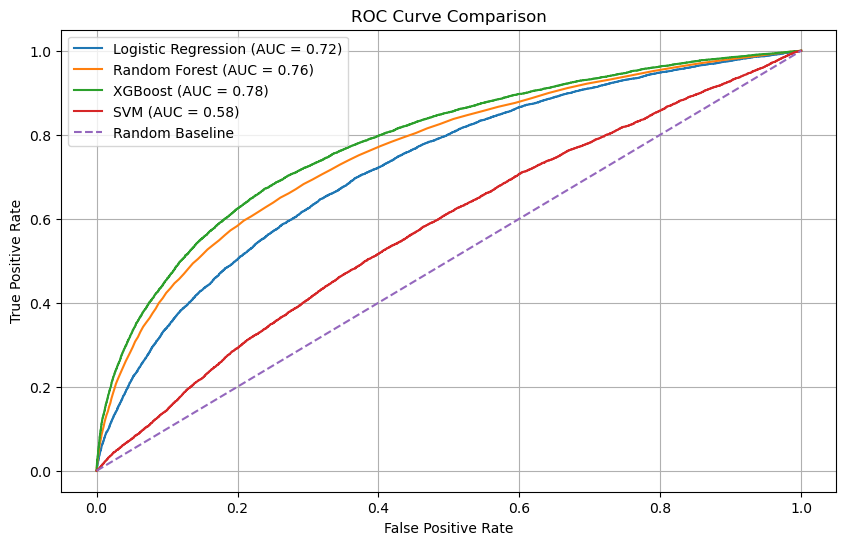

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, logreg_model.predict_proba(X_test)[:, 1])
auc_lr = roc_auc_score(y_test, logreg_model.predict_proba(X_test)[:, 1])

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
auc_rf = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
auc_xgb = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

# SVM
# For SVM, probabilities might not be available depending on the kernel; use `decision_function` instead
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_model.decision_function(X_test))
auc_svm = roc_auc_score(y_test, svm_model.decision_function(X_test))

# Plot ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {auc_svm:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random Baseline")

# Formatting the plot
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


## Most Important Features for each model

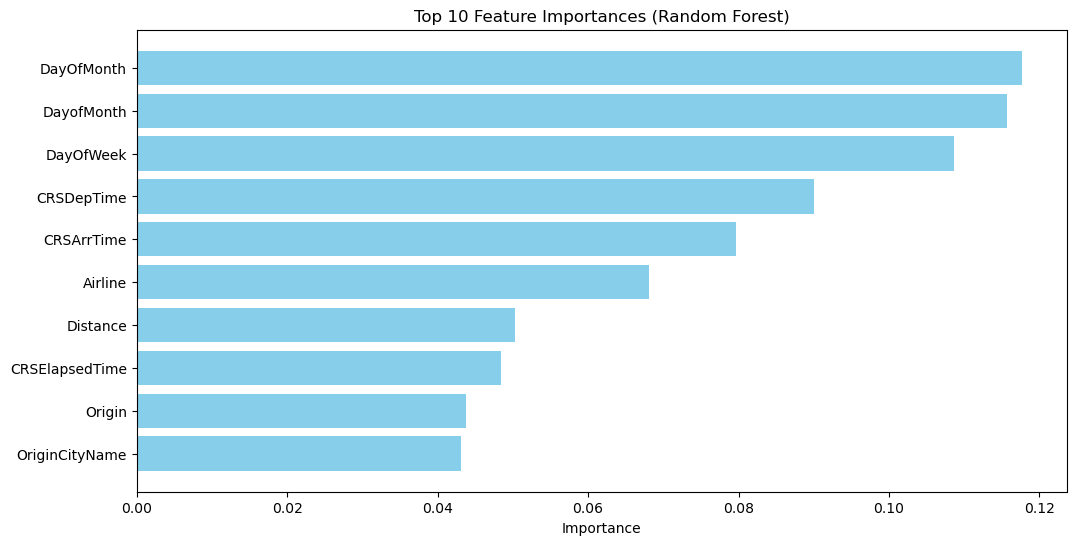

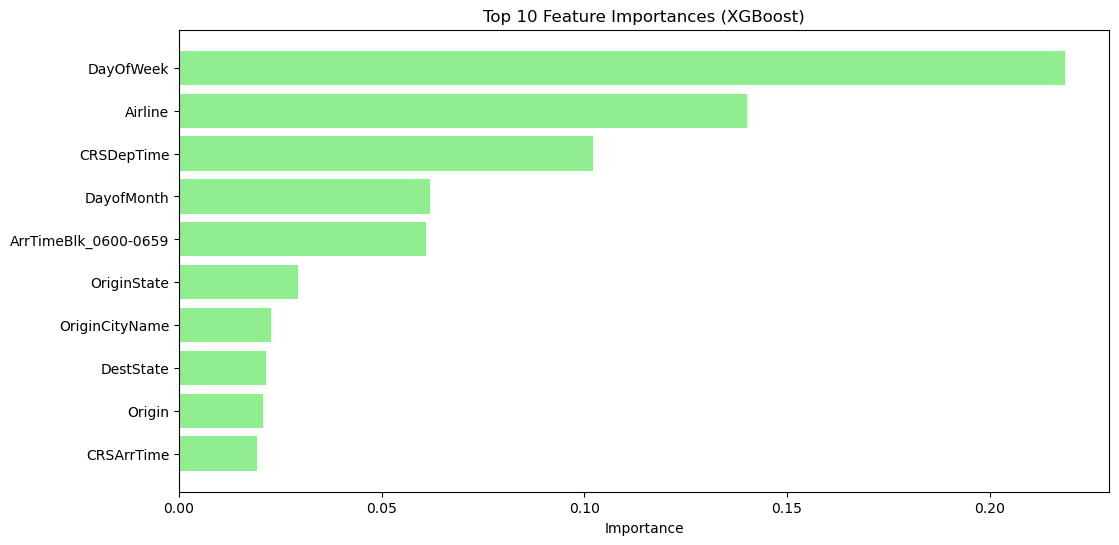

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming `rf_model` and `xgb_model` are trained models and `X` is the feature matrix

# Feature Importance from Random Forest
rf_importances = rf_model.feature_importances_
rf_features = X.columns

# Create a DataFrame for Random Forest feature importance
rf_importance_df = pd.DataFrame({
    'Feature': rf_features,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False).head(10)

# Feature Importance from XGBoost
xgb_importances = xgb_model.feature_importances_
xgb_features = X.columns

# Create a DataFrame for XGBoost feature importance
xgb_importance_df = pd.DataFrame({
    'Feature': xgb_features,
    'Importance': xgb_importances
}).sort_values(by='Importance', ascending=False).head(10)

# Plot Feature Importance for Random Forest
plt.figure(figsize=(12, 6))
plt.barh(rf_importance_df['Feature'], rf_importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()

# Plot Feature Importance for XGBoost
plt.figure(figsize=(12, 6))
plt.barh(xgb_importance_df['Feature'], xgb_importance_df['Importance'], color='lightgreen')
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.show()


## Training on Past and Predicting on Future Data with Best Parameters

In [20]:
df = pd.read_csv('dataset/Combined_Flights_2022.csv', nrows=200000)

# Drop post-event columns
post_event_columns = [
    'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime', 'ArrDelayMinutes', 
    'AirTime', 'ActualElapsedTime', 'DepartureDelayGroups', 'TaxiOut', 
    'WheelsOff', 'WheelsOn', 'TaxiIn', 'ArrDelay', 'ArrDel15', 
    'ArrivalDelayGroups', 'DivAirportLandings'
]
df = df.drop(columns=post_event_columns)

# Drop additional columns based on your list
columns_to_drop = [
    'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
    'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline', 'DOT_ID_Operating_Airline', 
    'IATA_Code_Operating_Airline', 'Tail_Number', 'Flight_Number_Marketing_Airline', 
    'Flight_Number_Operating_Airline', 'OriginAirportID', 'OriginAirportSeqID', 
    'OriginCityMarketID', 'OriginStateFips', 'OriginStateName', 'OriginWac', 
    'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestStateFips', 
    'DestStateName', 'DestWac', 'DistanceGroup','Operating_Airline'
]
df = df.drop(columns=columns_to_drop)

# Drop rows with missing values
df = df.dropna()

# Check for missing values after dropping
if df.isnull().sum().sum() > 0:
    print("There are still missing values in the dataset.")
else:
    print("No missing values left after dropping.")

# Convert 'FlightDate' to datetime and extract date-based features
df['FlightDate'] = pd.to_datetime(df['FlightDate'], errors='coerce')

# Check how many 'FlightDate' are NaT after conversion
print(f"Missing 'FlightDate' values: {df['FlightDate'].isnull().sum()}")

# Set the split date
split_date = pd.to_datetime('2022-04-25')

# Extract date-based features
df['DayOfWeek'] = df['FlightDate'].dt.dayofweek  # 0=Monday, 6=Sunday
df['Month'] = df['FlightDate'].dt.month  # 1=January, 12=December
df['DayOfMonth'] = df['FlightDate'].dt.day  # Day of the month (1-31)
df['Year'] = df['FlightDate'].dt.year  # Year (e.g., 2022)

# Encode low-cardinality categorical columns with one-hot encoding
low_cardinality_cols = ['DepTimeBlk', 'ArrTimeBlk']
df = pd.get_dummies(df, columns=low_cardinality_cols, drop_first=True)

# Encode high-cardinality categorical columns with label encoding
high_cardinality_cols = ['Airline', 'Origin', 'Dest', 'OriginCityName', 'OriginState', 'DestCityName', 'DestState']
label_encoders = {}
for col in high_cardinality_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Verify all features are numeric
non_numeric_columns = df.select_dtypes(include=['object']).columns
if not non_numeric_columns.empty:
    print(f"Remaining non-numeric columns: {list(non_numeric_columns)}")
else:
    print("All features are numeric. Proceeding with scaling.")

# Split the data based on the date
train_df = df[df['FlightDate'] < split_date]
test_df = df[df['FlightDate'] >= split_date]

# Check if train and test sets are empty after the split
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

# If any of the datasets are empty, review the split
if len(train_df) == 0 or len(test_df) == 0:
    print("Data split resulted in empty train or test sets. Review the filtering condition.")
else:
    # Drop 'FlightDate' from train and test sets
    X_train = train_df.drop(columns=['DepDel15', 'FlightDate'])  # Drop 'FlightDate' as it should not be used as a feature
    y_train = train_df['DepDel15']

    X_test = test_df.drop(columns=['DepDel15', 'FlightDate'])  # Drop 'FlightDate' as it should not be used as a feature
    y_test = test_df['DepDel15']

    # Scale features for both train and test sets
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Resample with SMOTE to address class imbalance
    sm = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

    # Verify the resampled data size
    print(f"Resampled training set size: {len(X_train_resampled)}")
    print(f"Resampled labels size: {len(y_train_resampled)}")

No missing values left after dropping.
Missing 'FlightDate' values: 0
All features are numeric. Proceeding with scaling.
Training set size: 157020
Test set size: 39490
Resampled training set size: 230980
Resampled labels size: 230980


In [22]:
optimized_xgb_model = XGBClassifier(
    subsample=0.7,
    n_estimators=200,
    max_depth=7,
    learning_rate=0.01,
    colsample_bytree=0.7,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Train the model on resampled data
optimized_xgb_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the test set
y_pred_optimized = optimized_xgb_model.predict(X_test_scaled)
y_pred_proba_optimized = optimized_xgb_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
print("Optimized XGBoost Classification Report:")
print(classification_report(y_test, y_pred_optimized))

# Confusion matrix
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
print("Confusion Matrix:")
print(cm_optimized)

# AUC-ROC
auc_optimized = roc_auc_score(y_test, y_pred_proba_optimized)
print(f"AUC-ROC Score: {auc_optimized:.2f}")

Optimized XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87     32329
         1.0       0.39      0.36      0.37      7161

    accuracy                           0.78     39490
   macro avg       0.62      0.62      0.62     39490
weighted avg       0.77      0.78      0.78     39490

Confusion Matrix:
[[28217  4112]
 [ 4566  2595]]
AUC-ROC Score: 0.72


In [23]:

print("Training SVM on scaled data (10K rows)...")
svm_model = SVC(kernel='linear', probability=True, max_iter=1000, random_state=42)

svm_model.fit(X_train_resampled, y_train_resampled)

# Evaluate SVM
y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_proba_svm = svm_model.decision_function(X_test_scaled)

print("SVM Evaluation:")
print(classification_report(y_test, y_pred_svm))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba_svm))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))


Training SVM on scaled data (10K rows)...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM Evaluation:
              precision    recall  f1-score   support

         0.0       0.83      0.72      0.77     32329
         1.0       0.21      0.34      0.26      7161

    accuracy                           0.65     39490
   macro avg       0.52      0.53      0.52     39490
weighted avg       0.72      0.65      0.68     39490

AUC-ROC Score: 0.5478460700417617
Confusion Matrix:
[[23303  9026]
 [ 4718  2443]]


In [24]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict(X_test_scaled)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85     32329
         1.0       0.37      0.41      0.39      7161

    accuracy                           0.77     39490
   macro avg       0.62      0.63      0.62     39490
weighted avg       0.78      0.77      0.77     39490



In [25]:
# Logistic Regression
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_resampled, y_train_resampled)
y_pred_logreg = logreg_model.predict(X_test_scaled)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87     32329
         1.0       0.38      0.36      0.37      7161

    accuracy                           0.78     39490
   macro avg       0.62      0.62      0.62     39490
weighted avg       0.77      0.78      0.78     39490



In [26]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.inspection import permutation_importance

# Load the dataset
df = pd.read_csv('dataset/Combined_Flights_2022.csv', nrows=200000)

# Drop irrelevant columns
columns_to_drop = ['DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime', 'ArrDelayMinutes', 'AirTime', 'ActualElapsedTime',
                   'DepartureDelayGroups', 'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn', 'ArrDelay', 'ArrDel15', 
                   'ArrivalDelayGroups', 'DivAirportLandings', 'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
                   'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline', 'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
                   'Tail_Number', 'Flight_Number_Marketing_Airline', 'Flight_Number_Operating_Airline', 'OriginAirportID',
                   'OriginAirportSeqID', 'OriginCityMarketID', 'OriginStateFips', 'OriginStateName', 'OriginWac', 
                   'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestStateFips', 'DestStateName', 'DestWac',
                   'DistanceGroup', 'Operating_Airline']

df = df.drop(columns=columns_to_drop)

# Drop rows with missing values
df = df.dropna()

# Convert 'FlightDate' to datetime and extract date-based features
df['FlightDate'] = pd.to_datetime(df['FlightDate'], errors='coerce')
df['DayOfWeek'] = df['FlightDate'].dt.dayofweek  # 0=Monday, 6=Sunday
df['Month'] = df['FlightDate'].dt.month  # 1=January, 12=December
df['DayOfMonth'] = df['FlightDate'].dt.day  # Day of the month (1-31)
df['Year'] = df['FlightDate'].dt.year  # Year (e.g., 2022)
df = df.drop(columns=['FlightDate'])

# Encode categorical variables (one-hot encoding or label encoding)
low_cardinality_cols = ['DepTimeBlk', 'ArrTimeBlk']
df = pd.get_dummies(df, columns=low_cardinality_cols, drop_first=True)

high_cardinality_cols = ['Airline', 'Origin', 'Dest', 'OriginCityName', 'OriginState', 'DestCityName', 'DestState']
label_encoders = {}
for col in high_cardinality_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Define features (X) and target (y)
X = df.drop(columns=['DepDel15'])  # Features
y = df['DepDel15']  # Target

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Apply scaling to the features

# Split data into train/test sets after scaling
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Isolation Forest model
iso_forest = IsolationForest(random_state=42, n_jobs=-1)
iso_forest.fit(X_train)

# Get predictions from Isolation Forest
iso_forest_preds = iso_forest.predict(X_test)
iso_forest_preds = [1 if x == -1 else 0 for x in iso_forest_preds]  # Convert predictions (-1 for anomaly, 1 for normal)

# Evaluate with AUC score
auc = roc_auc_score(y_test, iso_forest_preds)
print("Isolation Forest AUC: ", auc)

# Feature importance using permutation importance
result = permutation_importance(
    iso_forest, X_train, y_train, 
    n_repeats=10, random_state=42, scoring='roc_auc'
)

# Convert the resampled data back to DataFrame (for feature names access)
X_train_resampled_df = pd.DataFrame(X_train, columns=X.columns)  # Ensure to use original column names
X_test_resampled_df = pd.DataFrame(X_test, columns=X.columns)  # Create a DataFrame for X_test

# Get and sort feature importances
importances = result.importances_mean
feature_importance_df = pd.DataFrame({
    'Feature': X_train_resampled_df.columns,
    'Importance': importances
})

# Calculate percentage importance
feature_importance_df['Percentage'] = (feature_importance_df['Importance'] / feature_importance_df['Importance'].sum()) * 100

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Filter features with positive importance
positive_importance_features = feature_importance_df[feature_importance_df['Importance'] > 0]

# Print features with positive importance and their percentages
print("Features with positive importance and percentages:")
print(positive_importance_features[['Feature', 'Importance', 'Percentage']])

# Modify the dataset to include only features with positive importance (keep as DataFrame)
X_train_filtered = X_train_resampled_df[positive_importance_features['Feature']]
X_test_filtered = X_test_resampled_df[positive_importance_features['Feature']]

# --------------- TRAIN A NEW ISOLATION FOREST MODEL USING THE SELECTED FEATURES ---------------

# Train a new Isolation Forest model on the filtered features
iso_forest_filtered = IsolationForest(random_state=42, n_jobs=-1)
iso_forest_filtered.fit(X_train_filtered)

# Get predictions for the test set
iso_forest_preds = iso_forest_filtered.predict(X_test_filtered)
iso_forest_preds = [1 if x == -1 else 0 for x in iso_forest_preds]  # Convert predictions (-1 for anomaly, 1 for normal)

# Evaluate the model using AUC score
auc = roc_auc_score(y_test, iso_forest_preds)
print("New Isolation Forest AUC: ", auc)

# Classification Report (optional for evaluating anomalies)
print("New Isolation Forest Classification Report:")
print(classification_report(y_test, iso_forest_preds))

Isolation Forest AUC:  0.5
Features with positive importance and percentages:
                 Feature  Importance  Percentage
40  ArrTimeBlk_0900-0959    0.033298   29.230173
21  DepTimeBlk_0800-0859    0.028032   24.607496
19  DepTimeBlk_0600-0659    0.026076   22.890598
41  ArrTimeBlk_1000-1059    0.022543   19.788852
42  ArrTimeBlk_1100-1159    0.022113   19.411652
20  DepTimeBlk_0700-0759    0.019682   17.277105
22  DepTimeBlk_0900-0959    0.017363   15.241969
23  DepTimeBlk_1000-1059    0.015044   13.206337
38  ArrTimeBlk_0700-0759    0.013568   11.910358
44  ArrTimeBlk_1300-1359    0.012920   11.341502
39  ArrTimeBlk_0800-0859    0.012060   10.586496
0                Airline    0.009956    8.739708
24  DepTimeBlk_1100-1159    0.009837    8.635010
43  ArrTimeBlk_1200-1259    0.009778    8.583642
25  DepTimeBlk_1200-1259    0.007916    6.949335
45  ArrTimeBlk_1400-1459    0.007215    6.333123
14           OriginState    0.005510    4.836579
1                 Origin    0.002894    